In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session= Session(engine)

In [9]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fbae8a32b0>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fbaaba2a00>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397'}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date

('2017-08-23',)

In [12]:
new_date = dt.datetime.strptime(date[0], '%Y-%m-%d')
start_date = new_date-dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,func.sum(Measurement.prcp)).\
    filter(Measurement.date >= '2016-08-23').\
    group_by(Measurement.date).order_by(Measurement.date).all()
precipitation

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(precipitation, columns=["date","prcp"])
precipitation_df.dropna()
precipitation_df.set_index('date')
precipitation_df.sort_values(by =["date"])
precipitation_df.head()




,date,prcp
0,2016-08-23,2.71
1,2016-08-24,9.33
2,2016-08-25,0.54
3,2016-08-26,0.10
4,2016-08-27,0.32


Text(0, 0.5, 'Inches')

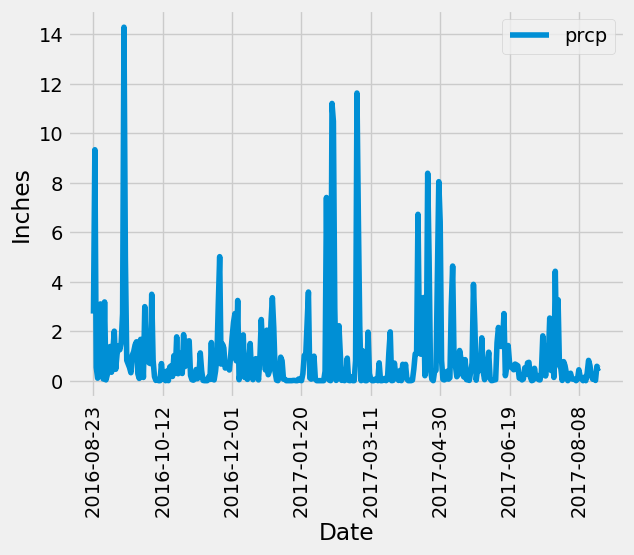

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='prcp', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
totalstation = session.query(Station.station).count()
totalstation


9

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()    


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').\
    group_by(Measurement.station).all()
    
   

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
active= session.query(Measurement.date,Measurement.tobs).\
    filter(func.strftime(Measurement.date)>= '2016-08-23', Measurement.station=='USC00519281').all()
  
active_df= pd.DataFrame(active, columns=["Date", "Temperature"])  
active_df.head()

,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


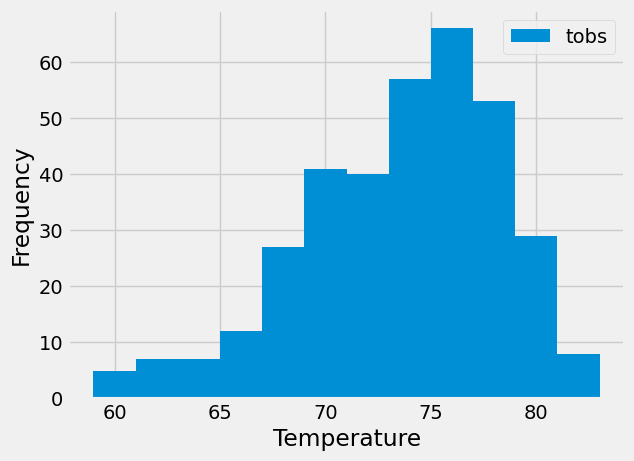

In [20]:
# plot the results as a histogram
plt.hist(active_df['Temperature'], bins =12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close session

In [21]:
# Close Session
session.close()